In [63]:
!pip install awswrangler

# Installing and importing packages and reading in the data

In [64]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
#import awswrangler as wr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 500)

In [65]:
#df = wr.s3.read_csv('s3://dsp-data-vq22301/dataset_drop_md.csv')
df = pd.read_csv("data/simfin_panel.csv")
df["public_date"] = pd.to_datetime(df["public_date"])

# Setting up Variables...

In [66]:
glossary = {
    'CAPEI': {'Ratio': 'Shillers Cyclically Adjusted P/E Ratio', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to 5-year moving average of Net Income'},
    'bm': {'Ratio': 'Book/Market', 'Category': 'Valuation', 'Formula': 'Book Value of Equity as a fraction of Market Value of Equity'},
    'evm': {'Ratio': 'Enterprise Value Multiple', 'Category': 'Valuation', 'Formula': 'Multiple of Enterprise Value to EBITDA'},
    'pe_op_basic': {'Ratio': 'Price/Operating Earnings (Basic, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Basic)'},
    'pe_op_dil': {'Ratio': 'Price/Operating Earnings (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price to Operating EPS, excl. Extraordinary Items (Diluted)'},
    'pe_exi': {'Ratio': 'P/E (Diluted, Excl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted)'},
    'pe_inc': {'Ratio': 'P/E (Diluted, Incl. EI)', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, incl. Extraordinary Items (diluted)'},
    'ps': {'Ratio': 'Price/Sales', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Sales'},
    'pcf': {'Ratio': 'Price/Cash flow', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Net Cash Flow from Operating Activities'},
    'dpr': {'Ratio': 'Dividend Payout Ratio', 'Category': 'Valuation', 'Formula': 'Dividends as a fraction of Income Before Extra. Items'},
    'npm': {'Ratio': 'Net Profit Margin', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of Sales'},
    'opmbd': {'Ratio': 'Operating Profit Margin Before Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of Sales'},
    'opmad': {'Ratio': 'Operating Profit Margin After Depreciation', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of Sales'},
    'gpm': {'Ratio': 'Gross Profit Margin', 'Category': 'Profitability', 'Formula': 'Gross Profit as a fraction of Sales'},
    'ptpm': {'Ratio': 'Pre-tax Profit Margin', 'Category': 'Profitability', 'Formula': 'Pretax Income as a fraction of Sales'},
    'cfm': {'Ratio': 'Cash Flow Margin', 'Category': 'Financial Soundness', 'Formula': 'Income before Extraordinary Items and Depreciation as a fraction of Sales'},
    'roa': {'Ratio': 'Return on Assets', 'Category': 'Profitability', 'Formula': 'Operating Income Before Depreciation as a fraction of average TotalAssets based on most recent two periods'},
    'roe': {'Ratio': 'Return on Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average Book Equity based on most recent two periods, where Book Equity is defined as the sum of Total Parent Stockholders Equity and Deferred Taxes and Investment Tax Credit'},
    'roce': {'Ratio': 'Return on Capital Employed', 'Category': 'Profitability', 'Formula': 'Earnings Before Interest and Taxes as a fraction of average Capital Employed based on most recent two periods, where Capital Employed is the sum of Debt in Long-term and Current Liabilities and Common/Ordinary Equity'},
    'efftax': {'Ratio': 'Effective Tax Rate', 'Category': 'Profitability', 'Formula': 'Income Tax as a fraction of Pretax Income'},
    'aftret_eq': {'Ratio': 'After-tax Return on Average Common Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Common Equity based on most recent two periods'},
    'aftret_invcapx': {'Ratio': 'After-tax Return on Invested Capital', 'Category': 'Profitability', 'Formula': 'Net Income plus Interest Expenses as a fraction of Invested Capital'},
    'aftret_equity': {'Ratio': 'After-tax Return on Total Stockholders’ Equity', 'Category': 'Profitability', 'Formula': 'Net Income as a fraction of average of Total Shareholders’ Equity based on most recent two periods'},
    'pretret_noa': {'Ratio': 'Pre-tax return on Net Operating Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Net Operating Assets (NOA) based on most recent two periods, where NOA is defined as the sum of Property Plant and Equipment and Current Assets minus Current Liabilities'},
    'pretret_earnat': {'Ratio': 'Pre-tax Return on Total Earning Assets', 'Category': 'Profitability', 'Formula': 'Operating Income After Depreciation as a fraction of average Total Earnings Assets (TEA) based on most recent two periods, where TEA is defined as the sum of Property Plant and Equipment and Current Assets'},
    'GProf': {'Ratio': 'Gross Profit/Total Assets', 'Category': 'Profitability', 'Formula': 'Gross Profitability as a fraction of Total Assets'},
    'equity_invcap': {'Ratio': 'Common Equity/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Common Equity as a fraction of Invested Capital'},
    'debt_invcap': {'Ratio': 'Long-term Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Long-term Debt as a fraction of Invested Capital'},
    'totdebt_invcap': {'Ratio': 'Total Debt/Invested Capital', 'Category': 'Capitalisation', 'Formula': 'Total Debt (Long-term and Current) as a fraction of Invested Capital'},
    'capital_ratio': {'Ratio': 'Capitalization Ratio', 'Category': 'Capitalisation', 'Formula': 'Total Long-term Debt as a fraction of the sum of Total Long-term Debt, Common/Ordinary Equity and Preferred Stock'},
    'int_debt': {'Ratio': 'Interest/Average Long-term Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Long-term debt based on most recent two periods'},
    'int_totdebt': {'Ratio': 'Interest/Average Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Interest as a fraction of average Total Debt based on most recent two periods'},
    'cash_lt': {'Ratio': 'Cash Balance/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Cash Balance as a fraction of Total Liabilities'},
    'invt_act': {'Ratio': 'Inventory/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Inventories as a fraction of Current Assets'},
    'rect_act': {'Ratio': 'Receivables/Current Assets', 'Category': 'Financial Soundness', 'Formula': 'Accounts Receivables as a fraction of Current Assets'},
    'debt_at': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Liabilities as a fraction of Total Assets'},
    'debt_ebitda': {'Ratio': 'debt_ebitda', 'Category': 'Financial Soundness', 'Formula': 'Gross Debt as a fraction of EBITDA'},
    'short_debt': {'Ratio': 'Short-Term Debt/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Short-term Debt as a fraction of Total Debt'},
    'curr_debt': {'Ratio': 'Current Liabilities/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Current Liabilities as a fraction of Total Liabilities'},
    'lt_debt': {'Ratio': 'Long-term Debt/Total Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Long-term Debt as a fraction of Total Liabilities'},
    'profit_lct': {'Ratio': 'Profit Before Depreciation/Current Liabilities', 'Category': 'Financial Soundness', 'Formula': 'Operating Income before D&A as a fraction of Current Liabilities'},
    'ocf_lct': {'Ratio': 'Operating CF/Current Liabilities', 'Category': 'Financial Soundess', 'Formula': 'Operating Cash Flow as a fraction of Current Liabilities'},
    'cash_debt': {'Ratio': 'Cash Flow/Total Debt', 'Category': 'Financial Soundness', 'Formula': 'Operating Cash Flow as a fraction of Total Debt'},
    'fcf_ocf': {'Ratio': 'Free Cash Flow/Operating Cash Flow', 'Category': 'Financial Soundness', 'Formula': 'Free Cash Flow as a fraction of Operating Cash Flow, where Free Cash Flow is defined as the difference between Operating Cash Flow and Capital Expenditures'},
    'lt_ppent': {'Ratio': 'Total Liabilities/Total Tangible Assets', 'Category': 'Financial Soundness', 'Formula': 'Total Liabilities to Total Tangible Assets'},
    'dltt_be': {'Ratio': 'Long-term Debt/Book Equity', 'Category': 'Financial Soundess', 'Formula': 'Long-term Debt to Book Equity'},
    'debt_assets': {'Ratio': 'Total Debt/Total Assets', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Assets'},
    'debt_capital': {'Ratio': 'Total Debt/Capital', 'Category': 'Solvency', 'Formula': 'Total Debt as a fraction of Total Capital, where Total Debt is defined as the sum of Accounts Payable and Total Debt in Current and Long-term Liabilities, and Total Capital is defined as the sum of Total Debt and Total Equity (common and preferred)'},
    'de_ratio': {'Ratio': 'Total Debt/Equity', 'Category': 'Solvency', 'Formula': 'Total Liabilities to Shareholders’ Equity (common and preferred)'},
    'intcov': {'Ratio': 'After-tax Interest Coverage', 'Category': 'Solvency', 'Formula': 'Multiple of After-tax Income to Interest and Related Expenses'},
    'intcov_ratio': {'Ratio': 'Interest Coverage Ratio', 'Category': 'Solvency', 'Formula': 'Multiple of Earnings Before Interest and Taxes to Interest and Related Expenses'},
    'cash_ratio': {'Ratio': 'Cash Ratio', 'Category': 'Liquidity', 'Formula': 'Cash and Short-term Investments as a fraction of Current Liabilities'},
    'quick_ratio': {'Ratio': 'Quick Ratio (Acid Test)', 'Category': 'Liquidity', 'Formula': 'Quick Ratio: Current Assets net of Inventories as a fraction of Current Liabilities'},
    'curr_ratio': {'Ratio': 'Current Ratio', 'Category': 'Liquidity', 'Formula': 'Current Assets as a fraction of Current Liabilities'},
    'cash_conversion': {'Ratio': 'Cash Conversion Cycle (Days)', 'Category': 'Liquidity', 'Formula': 'Inventories per daily COGS plus Account Receivables per daily Sales minus Account Payables per daily COGS'},
    'inv_turn': {'Ratio': 'Inventory Turnover', 'Category': 'Efficiency', 'Formula': 'COGS as a fraction of the average Inventories based on the most recent two periods'},
    'at_turn': {'Ratio': 'Asset Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average Total Assets based on the most recent two periods'},
    'rect_turn': {'Ratio': 'Receivables Turnover', 'Category': 'Efficiency', 'Formula': 'Sales as a fraction of the average of Accounts Receivables based on the most recent two periods'},
    'pay_turn': {'Ratio': 'Payables Turnover', 'Category': 'Efficiency', 'Formula': 'COGS and change in Inventories as a fraction of the average of Accounts Payable based on the most recent two periods'},
    'sale_invcap': {'Ratio': 'Sales/Invested Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Invested Capital'},
    'sale_equity': {'Ratio': 'Sales/Stockholders Equity', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of total Stockholders’ Equity'},
    'sale_nwc': {'Ratio': 'Sales/Working Capital', 'Category': 'Efficiency', 'Formula': 'Sales per dollar of Working Capital, defined as difference between Current Assets and Current Liabilities'},
    'rd_sale': {'Ratio': 'Research and Development/Sales', 'Category': 'Other', 'Formula': 'R&D expenses as a fraction of Sales'},
    'adv_sale': {'Ratio': 'Avertising Expenses/Sales', 'Category': 'Other', 'Formula': 'Advertising Expenses as a fraction of Sales'},
    'staff_sale': {'Ratio': 'Labor Expenses/Sales', 'Category': 'Other', 'Formula': 'Labor Expenses as a fraction of Sales'},
    'accrual': {'Ratio': 'Accruals/Average Assets', 'Category': 'Other', 'Formula': 'Accruals as a fraction of average Total Assets based on most recent two periods'},
    'ptb': {'Ratio': 'Price/Book', 'Category': 'Valuation', 'Formula': 'Multiple of Market Value of Equity to Book Value of Equity'},
    'PEG_trailing': {'Ratio': 'Trailing P/E to Growth (PEG) ratio', 'Category': 'Valuation', 'Formula': 'Price-to-Earnings, excl. Extraordinary Items (diluted) to 3-Year past EPS Growth'},
    'divyield': {'Ratio': 'Dividend Yield', 'Category': 'Valuation', 'Formula': 'Indicated Dividend Rate as a fraction of Price'}
}

inputs = ['CAPEI', 'bm',
       'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf',
       'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity',
       'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap',
       'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt',
       'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct',
       'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets',
       'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing',
       'divyield', 'MthCap', 'FEDFUNDS', '1yr_inf_rate', '1mo_inf_rate', '1yr_GDP', '1mo_GDP', 'DGS10']

missing = [c for c in inputs if c not in df.columns]
print("Missing inputs:", missing)

inputs = [c for c in inputs if c in df.columns]

target = '1yr_return'

# keep only rows where target exists
df = df.dropna(subset=[target]).copy()

# (also recommended) ensure y is numeric
df[target] = pd.to_numeric(df[target], errors="coerce")

# replace inf/-inf with NaN, then drop
df[target] = df[target].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=[target]).copy()

# optional: clip extreme outliers (keeps RF stable)
#df[target] = df[target].clip(lower=-0.95, upper=10.0)

Missing inputs: ['CAPEI', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'adv_sale', 'staff_sale', 'PEG_trailing']


# Cleaning and Data Preparation

## 1) Drop NaN values

The random forest model does not handle missing data well. Therefore, we will drop the columns with too many NaN values as they are less likely to be useful to the model and it will help us avoid dropping too many instances and therefore losing valuable information. Most of these are trailing ratios or lesser known variants.

In [67]:
df_inputs_with_names = df[inputs].copy()

In [68]:
for col in df_inputs_with_names.columns:
    try:
        df_inputs_with_names = df_inputs_with_names.rename(columns={col: f'{col} - ' + f'{glossary[col]["Ratio"]} - ' + f'{glossary[col]["Category"]}'.upper()})
    except:
        pass

In [69]:
df_inputs_with_names.isnull().sum()

bm - Book/Market - VALUATION                                                         191245
evm - Enterprise Value Multiple - VALUATION                                          313869
pe_op_basic - Price/Operating Earnings (Basic, Excl. EI) - VALUATION                 178532
pe_op_dil - Price/Operating Earnings (Diluted, Excl. EI) - VALUATION                 178532
pe_exi - P/E (Diluted, Excl. EI) - VALUATION                                         178527
pe_inc - P/E (Diluted, Incl. EI) - VALUATION                                         178527
ps - Price/Sales - VALUATION                                                         193847
pcf - Price/Cash flow - VALUATION                                                    178445
dpr - Dividend Payout Ratio - VALUATION                                              178527
npm - Net Profit Margin - PROFITABILITY                                              193847
opmbd - Operating Profit Margin Before Depreciation - PROFITABILITY             

In [70]:
print("Rows with any fundamentals attached:",
      df["Revenue_ttm"].notna().mean() if "Revenue_ttm" in df.columns else "no Revenue_ttm col")

print(df[["bm","ps","pcf","roa","roe","curr_ratio"]].notna().mean().sort_values())

Rows with any fundamentals attached: 0.5332564444594263
ps            0.533256
roe           0.539035
roa           0.539064
curr_ratio    0.539083
bm            0.539522
pcf           0.570341
dtype: float64


In [71]:
cols_to_drop = []
cols_to_keep = []

for i, value in enumerate(df_inputs_with_names.isnull().sum()):
    if value > 300000:
        cols_to_drop.append(df[inputs].columns[i])
    else:
        cols_to_keep.append(df[inputs].columns[i])

In [72]:
print(len(df[cols_to_keep]), len(cols_to_drop), len(df[cols_to_keep].dropna(how='any')))

415318 4 22861


## 2) Date formatting and sorting

Let's also format dates correctly and sort the df by gvkey and public_date in ascending order.

In [73]:
df['public_date'] = pd.to_datetime(df['public_date'])
df = df.sort_values("public_date", ascending=True).reset_index(drop=True)
print(df.loc[0, "public_date"], df.loc[len(df)-1, "public_date"])

2015-11-30 00:00:00 2024-09-30 00:00:00


In [74]:
df = df.sort_values(by=['gvkey', 'public_date'], ascending=True)

# Grid Search with Cross Validation for Optimal Model Hyperparameters

Let's use grid search on the two important hyperparameters for RF, maximum depth and number of tree estimators. Let's first select a bootstrap sample of 10% of the full dataset to use to reduce the computational complexity of the task. Due to the sheer size of our total dataset (2.5m instances), this is unlikely to affect performance in any way.

In [75]:
df = df.reset_index(drop=True)
X = df[cols_to_keep].dropna().sample(frac=0.1, replace=True, random_state=777)  # take a bootstrap sample to decrease training time
y = df['1yr_return'].loc[X.index]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

Let's use 5-fold cross validation as well to ensure robustness of our results.

In [76]:
performance = [[[] for _ in range(11)] for _ in range(5)]
kf = KFold(5, shuffle=True, random_state=777)

for i, (train_index, val_index) in enumerate(kf.split(X)):
    
    Xtr, ytr = X.loc[train_index, :], y.loc[train_index]
    Xval, yval = X.loc[val_index,:], y.loc[val_index]
    
    for j, max_depth in enumerate(range(3, 14, 1)):
        
        for k, n_estimators in enumerate(range(50, 375, 25)):
            
            rf = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, max_samples=0.1, max_features='sqrt', random_state=777,n_jobs=-1)
            rf.fit(Xtr.to_numpy(), ytr.to_numpy())
            yval_pred = rf.predict(Xval.to_numpy())
            mse = mean_squared_error(yval, yval_pred)
            performance[i][j].append(mse)
            print(f'DONE: Fold {i}, Max Depth: {max_depth}, n_estimators: {n_estimators}, MSE: {mse}')

DONE: Fold 0, Max Depth: 3, n_estimators: 50, MSE: 0.29591689380523634
DONE: Fold 0, Max Depth: 3, n_estimators: 75, MSE: 0.2926139665852709
DONE: Fold 0, Max Depth: 3, n_estimators: 100, MSE: 0.29288699687670827
DONE: Fold 0, Max Depth: 3, n_estimators: 125, MSE: 0.294801926241489
DONE: Fold 0, Max Depth: 3, n_estimators: 150, MSE: 0.29585049743180375
DONE: Fold 0, Max Depth: 3, n_estimators: 175, MSE: 0.2979174038384063
DONE: Fold 0, Max Depth: 3, n_estimators: 200, MSE: 0.29885931298249807
DONE: Fold 0, Max Depth: 3, n_estimators: 225, MSE: 0.29881756060534
DONE: Fold 0, Max Depth: 3, n_estimators: 250, MSE: 0.2980851716461265
DONE: Fold 0, Max Depth: 3, n_estimators: 275, MSE: 0.2983781066249782
DONE: Fold 0, Max Depth: 3, n_estimators: 300, MSE: 0.2990243364507931
DONE: Fold 0, Max Depth: 3, n_estimators: 325, MSE: 0.29842629532236953
DONE: Fold 0, Max Depth: 3, n_estimators: 350, MSE: 0.2974145388449133
DONE: Fold 0, Max Depth: 4, n_estimators: 50, MSE: 0.3001489153686382
DONE: F

In [77]:
performance_means = []

for j in range(len(performance[0])):
    for k in range(len(performance[0][0])):
        performance_means.append(np.mean([performance[i][j][k] for i in range(len(performance))]))

best_setup = [1000, []]
for i, max_depth in enumerate(range(3, 14, 1)):
    for j, n_estimators in enumerate(range(50, 375, 25)):
        print(f'Max Depth = {max_depth} - n_estimators = {n_estimators} - Performance = {performance_means[(i*len(range(50, 375, 25))) + j]}')
        if performance_means[(i*len(range(50, 375, 25))) + j] < best_setup[0]:
              best_setup = [performance_means[(i*len(range(50, 375, 25))) + j], [max_depth, n_estimators]]

print(f'BEST SETUP:\nMax depth = {best_setup[1][0]}\nn_estimators = {best_setup[1][1]}')

Max Depth = 3 - n_estimators = 50 - Performance = 0.45197830662915645
Max Depth = 3 - n_estimators = 75 - Performance = 0.45701923651049103
Max Depth = 3 - n_estimators = 100 - Performance = 0.4580330127650399
Max Depth = 3 - n_estimators = 125 - Performance = 0.45963736369216956
Max Depth = 3 - n_estimators = 150 - Performance = 0.4585231917714598
Max Depth = 3 - n_estimators = 175 - Performance = 0.4589951197585247
Max Depth = 3 - n_estimators = 200 - Performance = 0.4591020960195487
Max Depth = 3 - n_estimators = 225 - Performance = 0.4587605817539712
Max Depth = 3 - n_estimators = 250 - Performance = 0.45776251524251244
Max Depth = 3 - n_estimators = 275 - Performance = 0.45741179195502435
Max Depth = 3 - n_estimators = 300 - Performance = 0.45756549074495334
Max Depth = 3 - n_estimators = 325 - Performance = 0.45590724942254457
Max Depth = 3 - n_estimators = 350 - Performance = 0.4557115592621628
Max Depth = 4 - n_estimators = 50 - Performance = 0.4513368365825519
Max Depth = 4 - 

Text(0.5, 1.0, 'Hyperparameter Optimisation Results')

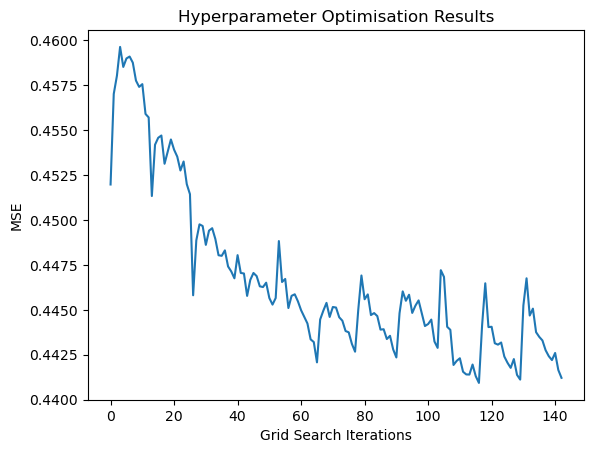

In [78]:
plt.plot(performance_means)
plt.ylabel('MSE')
plt.xlabel('Grid Search Iterations')
plt.title('Hyperparameter Optimisation Results')

It appears that gains for both `max_depth` and `n_estimators` begin to tail off after our upper limits on both in the grid search. We could try higher thresholds but in favour of minimising model complexity and in review of the miniscule gains in MSE, we will assume that the optimal model in our case has `max_depth` = 13 and `n_estimators` = 350.

# Model Simulation

Now let's run the model and induce on the data for each trading year, using an expanding window stretching back to 1971 as the training data. The window is constructed so as to avoid any lookahead bias. We need a minimum of approx. 10 years for our model to be fairly judged. Therefore, we will start testing the model from `1981-12-31` onwards.

We will store the results in individual csv files in our S3 bucket to be accessed later when evaluating results and constructing our LSTM (with the most important RF features).

In [79]:
sequence_start_year = '2015-12-31'

def get_portfolio_return(y_actual, y_pred, num_stocks=30):
    return np.mean(y_actual[y_pred.argsort()[-num_stocks:].tolist()])

def run_model(df=df, sequence_start_year='2015-12-31', allow_caps=['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']):
    years = sorted(df["public_date"].dt.year.unique())
    for year in years[1:-1]:  # skip early years without enough history/targets

        test_results = pd.DataFrame(columns=['prediction_yr', 'ret_mkt_avg', 'ret_30', 'ret_50', 'ret_100', 'ret_150', 'ret_200', 'mse', 'top_features', 'feature_importances_raw'])

        prediction_yr = f'{year}-12-31'
        train_end_yr = f'{int(prediction_yr[:4]) - 1}-12-31'
        
        if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
            df_train = df[df['public_date'].between(pd.to_datetime(sequence_start_year), pd.to_datetime(train_end_yr), inclusive='both')]
        else:
            df_train = df[np.logical_and(df.cap.isin(allow_caps), df['public_date'].between(pd.to_datetime(sequence_start_year), pd.to_datetime(train_end_yr), inclusive='both'))]
        Xtr = df_train[cols_to_keep].dropna(how='any')
        ytr = df_train[target].loc[Xtr.index]
        Xtr, ytr = Xtr.reset_index(drop=True), ytr.reset_index(drop=True)
        
        if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
            df_test = df[df['public_date'] == pd.to_datetime(prediction_yr)]
        else:
            df_test = df[np.logical_and(df.cap.isin(allow_caps), df['public_date'] == pd.to_datetime(prediction_yr))]
        Xtest = df_test[cols_to_keep].dropna(how='any')
        ytest = df_test[target].loc[Xtest.index]
        Xtest, ytest = Xtest.reset_index(drop=True), ytest.reset_index(drop=True)

        rf = RandomForestRegressor(max_depth=13, n_estimators=350, max_samples=0.1, max_features='sqrt', random_state=777)
        rf.fit(Xtr.to_numpy(), ytr.to_numpy())
        ytest_pred = rf.predict(Xtest.to_numpy())
        test_results.loc[0, 'prediction_yr'] = prediction_yr
        test_results.loc[0, 'ret_mkt_avg'] = np.mean(ytest)
        for num_stocks in [30, 50, 100, 150, 200]:
            test_results.loc[0, f'ret_{num_stocks}'] = get_portfolio_return(ytest, ytest_pred, num_stocks)
        test_results.loc[0, 'mse'] = mean_squared_error(ytest, ytest_pred)
        test_results.loc[0, 'top_features'] = np.array(cols_to_keep)[rf.feature_importances_.argsort().tolist()]
        test_results.loc[0, 'feature_importances_raw'] = np.sort(rf.feature_importances_)
        raw_test_output = pd.DataFrame({'ytest_pred_raw': ytest_pred})
        #if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
        #    wr.s3.to_csv(df=test_results, path=f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}.csv', index=False)
        #    wr.s3.to_csv(df=raw_test_output, path=f's3://dsp-data-vq22301/rf_test_results/rf_results_{year}_raw.csv', index=False)
        #else:
        #    wr.s3.to_csv(df=test_results, path=f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_{allow_caps[0][:2]}_{year}.csv', index=False)
        #    wr.s3.to_csv(df=raw_test_output, path=f's3://dsp-data-vq22301/rf_test_results/cap_limit_results/rf_results_{allow_caps[0][:2]}_{year}_raw.csv', index=False)

        import os
        
        # choose an output root (relative to repo)
        out_root = "outputs/rf_test_results"
        os.makedirs(out_root, exist_ok=True)
        
        if allow_caps == ['Nano Cap', 'Micro Cap', 'Small Cap', 'Mid Cap', 'Large Cap', 'Mega Cap']:
            # matches original "rf_test_results/" prefix
            test_results.to_csv(f"{out_root}/rf_results_{year}.csv", index=False)
            raw_test_output.to_csv(f"{out_root}/rf_results_{year}_raw.csv", index=False)
        else:
            # matches original "cap_limit_results/" subfolder
            cap_dir = f"{out_root}/cap_limit_results"
            os.makedirs(cap_dir, exist_ok=True)
        
            cap_code = allow_caps[0][:2]  # same as original (e.g., 'Na', 'Mi', etc.)
            test_results.to_csv(f"{cap_dir}/rf_results_{cap_code}_{year}.csv", index=False)
            raw_test_output.to_csv(f"{cap_dir}/rf_results_{cap_code}_{year}_raw.csv", index=False)
        print(f'DONE: {year}, Market Avg: {np.mean(ytest)}, Top 30 results: {get_portfolio_return(ytest, ytest_pred, 30)}')

First, we will run it with no cap limit.

In [80]:
run_model(df=df,
         sequence_start_year='2018-12-31',
         )

ValueError: Found array with 0 sample(s) (shape=(0, 60)) while a minimum of 1 is required by RandomForestRegressor.

Now, let's run it with the cap limit

In [ ]:
run_model(df=df,
         sequence_start_year='2015-12-31',
          allow_caps=['Mid Cap', 'Large Cap', 'Mega Cap']
         )

In [ ]:
print("inputs count:", len(inputs))
print(inputs)